# Inf 552 HW 1

### Group members: Minghong Xu, Zhixin Xie

#### Individual contributions: 
We cooperated together and completed this assignment.

## Part 1: Implementation

In [1]:
import math
import pandas as pd

In [2]:
txt_file = r"dt_data.txt"

In [3]:
df = pd.read_table(txt_file, skiprows = 0, sep = ', ', header = 0)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [4]:
df = df.rename(columns={'(Occupied': 'Occupied'})
df = df.rename(columns={'Enjoy)': 'Enjoy'})

df.Enjoy = df.Enjoy.str.replace(';', '')

df.Occupied = df.Occupied.str.replace(r'^(\d*)[:]*[\s]*','')

In [5]:
df.head()

,Occupied,Price,Music,Location,VIP,Favorite Beer,Enjoy
0,High,Expensive,Loud,Talpiot,No,No,No
1,High,Expensive,Loud,City-Center,Yes,No,Yes
2,Moderate,Normal,Quiet,City-Center,No,Yes,Yes
3,Moderate,Expensive,Quiet,German-Colony,No,No,No
4,Moderate,Expensive,Quiet,German-Colony,Yes,Yes,Yes


In [6]:
def entropy(l:list):
    e = 0
    for p in l:
        if p == 0 or p==1:
            pass
        else:
            e = e-p*math.log(p,2)
    return e

In [7]:
def p_list(df, column):
    l = []
    for i in df[column].value_counts():
        l.append(i/len(df))
    return l

In [8]:
def information_gain(df, column, label):
    entropy_before = entropy(p_list(df, label))
    entropy_after = 0
    for i in df[column].value_counts().keys():
        df_temp = df.loc[df[column] == i]
        entropy_after += entropy(p_list(df_temp, label))*(len(df_temp)/len(df))
    return entropy_before - entropy_after

In [9]:
information_gain(df, 'Occupied', 'Enjoy')

0.13831794174248158

In [10]:
def choose_best_column(df, label):
    best_column = 0
    max_infor = 0
    for i in df.columns:
        if i == label:
            return best_column
        infor = information_gain(df, i, label)
        if infor > max_infor:
            best_column = i
            max_infor = infor
    return best_column

In [11]:
choose_best_column(df, 'Enjoy')

'Occupied'

In [12]:
def create_tree(df, label):
    tree = {}
    best_column = choose_best_column(df, label)
    tree[best_column] = {}
    for i in df[best_column].value_counts().keys():
        dftemp = df.loc[df[best_column] == i] 
        #print(information_gain(dftemp, sub_best_column, label))
        if entropy(p_list(dftemp, label)) == 0:
            tree[best_column].update({i:dftemp[label].values[0]})
        elif choose_best_column(dftemp, label) == 0:
            tree[best_column].update({i:dftemp[label].value_counts().keys()[0]})
        else:
            tree[best_column].update({i:create_tree(dftemp, label)})
    return tree

In [13]:
decision_tree = create_tree(df, 'Enjoy') 

In [14]:
test_data = {'Occupied':'Moderate', 'Price' : 'Cheap', 'Music' : 'Loud', 'Location' : 'City-Center', 'VIP' : 'No', 'Favorite Beer' : 'No'}


In [15]:
def predict(tree, tdata):
    key = list(tree.keys())[0]
    value = tdata[key]
    result = tree
    while type(result) is dict:
        result = result[key][value]
        if type(result) is not dict:
            return result
        key = list(result.keys())[0]
        value = tdata[key]
    return result

In [16]:
predict(decision_tree, test_data)

'Yes'

In [17]:
decision_tree

{'Occupied': {'Moderate': {'Location': {'Ein-Karem': 'Yes',
    'German-Colony': {'VIP': {'No': 'No', 'Yes': 'Yes'}},
    'Mahane-Yehuda': 'Yes',
    'Talpiot': {'Price': {'Cheap': 'No', 'Normal': 'Yes'}},
    'City-Center': 'Yes'}},
  'Low': {'Location': {'City-Center': {'Price': {'Normal': 'No',
      'Cheap': 'No'}},
    'Ein-Karem': {'Price': {'Cheap': 'Yes', 'Normal': 'No'}},
    'Talpiot': 'No',
    'Mahane-Yehuda': 'No'}},
  'High': {'Location': {'City-Center': 'Yes',
    'Talpiot': 'No',
    'German-Colony': 'No',
    'Mahane-Yehuda': 'Yes'}}}}

In [18]:
count = 10
def number_dict(d):
    global count
    l = list(d.keys())
    for i in l:
        if type(d[i]) is dict:
            number_dict(d[i])
        d[i+str(count)] = d.pop(i)
        count += 1

In [19]:
def tuple_list(tree):
    l = []
    for i in tree:
        for j in tree[i]:
            if type(tree[i][j]) is not dict:
                l.append((i,tree[i][j],j))
            else:
                for k in tree[i][j]:
                    l.append((i,k,j))
                l = l + tuple_list(tree[i][j])
    return l

In [20]:
from graphviz import Digraph

def draw_tree(tree):
    gz=Digraph("Decision Tree",'comment',None,None,'png',None,"UTF-8",
               {'rankdir':'TB'},
               {'color':'black','fontcolor':'black','fontname':'FangSong','fontsize':'12','style':'rounded','shape':'box'},
               {'color':'#999999','fontcolor':'#888888','fontsize':'10','fontname':'FangSong'},None,False)
    treecopy = tree.copy()
    number_dict(treecopy)
    l = tuple_list(treecopy)
    for t in l:
        gz.node(t[0],t[0])
        gz.node(t[1],t[1])
        gz.edge(t[0],t[1],t[2])
    return gz

#gz.node('e','success',{'color':'red','fontcolor':'red'})

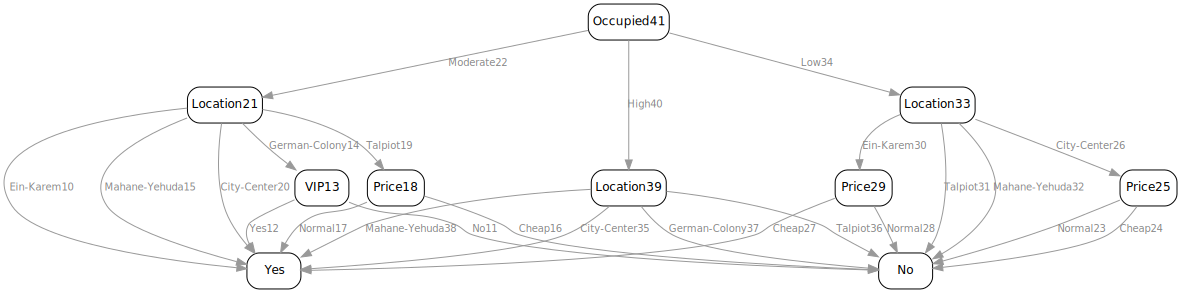

In [21]:
draw_tree(decision_tree)

Until here, the decision tree is implemented and printed. And the prediction result is 'Yes'.

First, we used ‘pandas’ package in Python to store the training data and cleaned it to the format as 'df' above. Then, we created functions to calculate Entropy and Information Gain. The most difficult part is constructing the tree. We tried many ways including while loops and global variables, but the only way could implement the algorithm well was recursion (which I found on my notebook later, should review lecture notes first). And the recursion was pretty complex. There were so many factors need to consider.

One code level optimization was also in ‘create_tree’ function. At first, we dropped the best column that had been used to avoid repetition, which created countless tables and made the code very complex. However, we found out later that there was no need to drop the used best column. Once the columns are used and divided into several categories, the information gain for this column at a specific category would be zero and would not influence further construction. Thus, we changed our code and now the ‘create_tree’ function only had 12 lines.

We chose a dictionary data structure in Python to store the decision tree since the dictionary had the concept of keys and values, which accorded with the decision tree's nodes and subtrees.

For the drawing part, because the package we used would merge all nodes with the same name. We had to number all the nodes in the decision tree. And for lack of enough programming skills, we cannot think out better methods and cannot split the nodes of the final result, but that does not influence the accuracy of the decision tree. There is also a dictionary format decision tree printed above.

## Part 2:Software Familiarization

Below is library function DecisionTreeClassifier.

In [22]:
# Load libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from IPython.display import Image  
from sklearn import tree
import pydotplus

In [23]:
txt_file = r"dt_data.txt"
df = pd.read_table(txt_file, skiprows = 0, sep = ', ', header = 0)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [24]:
df = df.rename(columns={'(Occupied': 'Occupied'})
df = df.rename(columns={'Enjoy)': 'Enjoy'})
df.Enjoy = df.Enjoy.str.replace(';', '')
df.Occupied = df.Occupied.str.replace(r'^(\d*)[:]*[\s]*','')

In [25]:
df['Enjoy'],class_names = pd.factorize(df['Enjoy'])
print(class_names)

Index(['No', 'Yes'], dtype='object')


In [26]:
df['Occupied'],_ = pd.factorize(df['Occupied'])
df['Price'],_ = pd.factorize(df['Price'])
df['Music'],_ = pd.factorize(df['Music'])
df['Location'],_ = pd.factorize(df['Location'])
df['VIP'],_ = pd.factorize(df['VIP'])
df['Favorite Beer'],_ = pd.factorize(df['Favorite Beer'])
df.head()

,Occupied,Price,Music,Location,VIP,Favorite Beer,Enjoy
0,0,0,0,0,0,0,0
1,0,0,0,1,1,0,1
2,1,1,1,1,0,1,1
3,1,0,1,2,0,0,0
4,1,0,1,2,1,1,1


In [27]:
# Load data
X = df.drop('Enjoy', axis=1)
y = df['Enjoy']

In [28]:
# Create decision tree classifer object
clf = DecisionTreeClassifier(criterion = 'entropy')

# Train model
dtmodel = clf.fit(X, y)

In [29]:
#Load Test Data
test_data = {'Occupied':1, 'Price' : 2, 'Music' : 0, 'Location' : 1, 'VIP' : 1, 'Favorite Beer' : 1}
test_df = pd.DataFrame(test_data,index=[0]) 

In [30]:
dtmodel.predict(test_df)
#[0:NO,1:YES]

array([1])

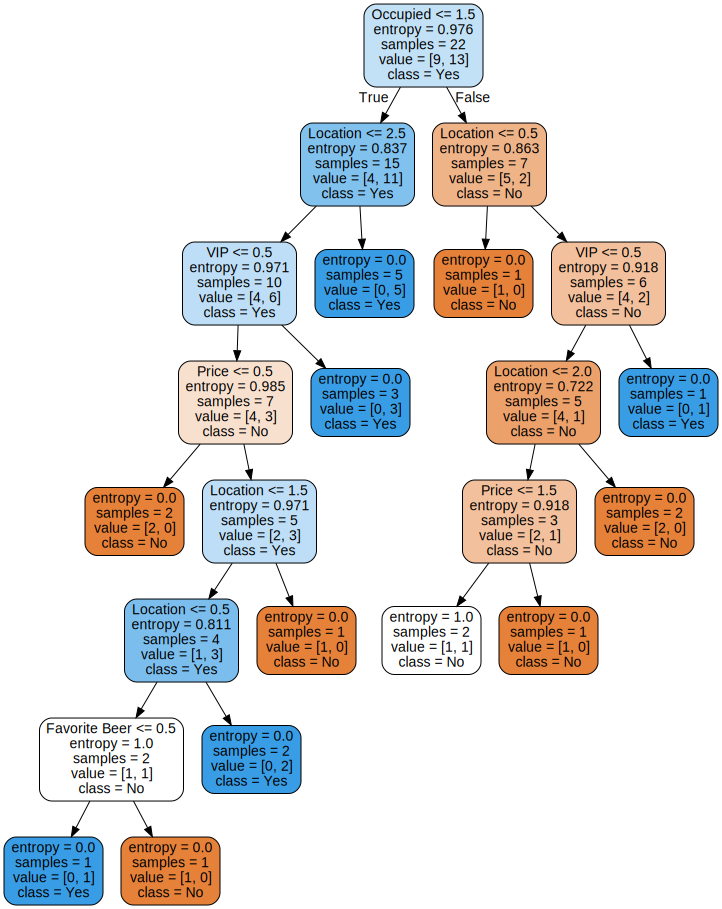

In [31]:
#Graph
import graphviz
feature_names = X.columns

dot_data = tree.export_graphviz(dtmodel, out_file=None, filled=True, rounded=True,
                                feature_names=feature_names,  
                                class_names=class_names)
graph = graphviz.Source(dot_data)  
graph

#### How to use it
The function we chose is ‘DecisionTreeClassifier’ from ‘sklearn.tree’. Since the model could only deal with numerical variables, we used the factorize method of the pandas library to convert the string categorical values into an integer code. We later assigned ‘Enjoy’ as target variable ‘y’, and others as feature variables ‘X’. We created the Decision Tree Model using Scikit-learn based on the dataset and predicted the given test data. The prediction result was '1' which meant ‘Yes’. Then we applied ‘export_graphviz’ function to display the tree.


#### Comparison
One of the biggest differences between our decision tree and python library's is that in our tree each node can have more than two subtrees. However, the nodes in sklearn package can only have two subtrees. This makes the decision tree be much deeper than ours, but it is still easy to use. 

And we can improve the code at create_tree part. We use three nested for loops, which will make the time consumption as high as O(n^3). And we even nest recursion inside the for loops. However, to improve these flaws, we need to have deeper understanding and more knowledge for coding. 


## Part 3:Real Life Application

### 1. Dating website

Each user in the dating platform often has some attribute values that can be seen by other users, such as age, location, occupation, interests, avatar photos, and so on.  The decision tree model is used to generate a personalized dating preference model for each user, and the candidate recommendation list is classified and ranked. When a user meets a new user, according to decision tree model, the attributes of the new user will predict the degree of preference that results, and then decide whether to recommend this new user out and prioritize recommendations.


### 2. Business Management

Management may face some uncomfortable situations to make some hard decisions. A decision tree can visualize certain alternative choices clearly and the consequences of these choices. It also can compare the costs and likely values to check whether a decision is worthwhile. Here is a true example. <https://gbr.pepperdine.edu/2010/08/how-gerber-used-a-decision-tree-in-strategic-decision-making/>

### 3. Predict personality traits

Project researchers found 50 students and recorded their sight data when students watched recorded high-resolution video on the scene with smartphones. Researched also collected students’ specific behavior data and their self-test questionnaires about personality. After data cleaning, the researchers divided each personality feature into 3 personality score ranges (low, medium, and high), and then they created a random forest classifier for each personality feature, consisting of 100 decision trees. After training the model, let the model predict the score of the personality in these three score ranges. <https://github.molgen.mpg.de/sabrina-hoppe/everyday-eye-movements-predict-personality>